In [2]:
import random
import numpy as np
from time import time
import inspyred
import itertools

In [3]:
def create_lamp_grid(grid_size, problem_size):
    da = 1/ grid_size
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    N = int(r * grid_size)
    lamp_grid = np.zeros((2*N+1, 2*N+1))
    for i in range(2*N+1):
        for j in range(2*N+1):
            x = (i-N) * da
            y = (j-N) * da
            if x**2 + y**2 <= r2:
                lamp_grid[i,j] = 1
    return lamp_grid

In [4]:
# Function to calculate the enlightened and overlap area
def calculate_areas(lamps, grid_size, problem_size, lamp_grid):
    r2 = 1 / problem_size / np.pi
    r = np.sqrt(r2)
    rN = lamp_grid.shape[0]
    extra = rN // 2
    # Initialize the grid
    tot_grid = np.zeros((grid_size + 2 * extra, grid_size + 2 * extra))
    
    # Illuminate the grid with each lamp
    for x, y in lamps:
        # Calculate the index of the lamp in the grid
        x_min = max(0, int(x * grid_size)-1)
        y_min = max(0, int(y * grid_size)-1)
        tot_grid[x_min:x_min+rN, y_min:y_min+rN] += lamp_grid

    # Remove the extra rows and columns
    tot_grid = tot_grid[extra:-extra, extra:-extra]
    # Count the enlightened and overlap area
    enlightened_area = np.sum(tot_grid > 0) / grid_size**2
    overlap_area = 1 / problem_size * len(lamps) - enlightened_area

    return enlightened_area, overlap_area

In [5]:
test_N = 3000
mat = create_lamp_grid(test_N, 3)
mat.shape

(1955, 1955)

In [6]:
lamps = [(0.25, 0.25), (0.75, 0.75), (0.25, 0.75), (0.75, 0.25)]
enlightened_area, overlap_area = calculate_areas(lamps, test_N, 3, mat)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.9872208888888889
Overlap area: 0.34611244444444433


In [9]:
# The Evaluator
def evaluator_lamp(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    weight_overlap = args.get('weight_overlap', 1)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, overlap_area = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append((enlightened_area - weight_overlap * overlap_area))
    return fitness

In [45]:
# The Generator
def generator_lamp(random, args):
    problem_size = args.get('problem_size')
    number_lamps = random.randint(problem_size, problem_size*3)
    return [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(number_lamps)] 

In [11]:
# The Bounder
def bound_lamp(candidate, args):
    for i, c in enumerate(candidate):
        x = max(min(c[0], 1), 0)
        y = max(min(c[1], 1), 0)
        candidate[i] = (x, y)
    return candidate
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [12]:
# The Observer
def observer_lamp(population, num_generations, num_evaluations, args):
    avg_len = np.mean([len(c.candidate) for c in population])
    best = max(population)
    print('{0:6} -- {1} : {2}'.format(num_generations, best.fitness, avg_len))

In [39]:
# Custom mutation operator
def mutate_lamp(random, candidates, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    bounder = args['_ec'].bounder
    for i, cs in enumerate(candidates):
        for j, (c, lo, hi) in enumerate(zip(cs, bounder.lower_bound, bounder.upper_bound)):
            if random.random() < mut_rate:
                x = c[0] + random.gauss(0, 0.1) * (hi - lo)
                y = c[1] + random.gauss(0, 0.1) * (hi - lo)
                candidates[i][j] = (x, y)
        candidates[i] = bounder(candidates[i], args)
    return candidates

In [46]:
rand = random.Random()
rand.seed(int(time()))
my_ec = inspyred.ec.EvolutionaryComputation(rand)
my_ec.selector = inspyred.ec.selectors.tournament_selection
my_ec.variator = [inspyred.ec.variators.uniform_crossover, 
                  mutate_lamp]
my_ec.replacer = inspyred.ec.replacers.plus_replacement
my_ec.observer = observer_lamp
my_ec.terminator = [inspyred.ec.terminators.evaluation_termination
                    ,inspyred.ec.terminators.average_fitness_termination]

In [56]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [57]:
final_pop = my_ec.evolve(generator = generator_lamp,
                         evaluator = evaluator_lamp,
                         pop_size = 100,
                         bounder = bound_lamp,
                         max_evaluations = 3000,
                         num_selected = 50,
                         crossover_rate = 0.2,
                         mutation_rate = 0.8,
                         # Custom args
                         problem_size = problem_size,
                         grid_size = grid_size,
                         lamp_grid = lamp_grid,
                         weight_overlap = 1)
print('Terminated due to {0}.'.format(my_ec.termination_cause))
final_pop.sort(reverse=True)
print(final_pop[0])

     0 -- 0.4078302222222223 : 9.18
     1 -- 0.4352391111111109 : 7.34
     2 -- 0.4352391111111109 : 6.06
     3 -- 0.6229377777777778 : 5.68
     4 -- 0.42759199999999975 : 5.66
     5 -- 0.42759199999999975 : 5.66
     6 -- 0.455478222222222 : 5.66
     7 -- 0.455478222222222 : 5.7
     8 -- 0.46014577777777776 : 5.78
     9 -- 0.5085662222222223 : 5.84
    10 -- 0.5085662222222223 : 5.84
    11 -- 0.5085662222222223 : 5.8
    12 -- 0.5085662222222223 : 5.8
    13 -- 0.5085662222222223 : 5.64
    14 -- 0.5368942222222222 : 5.5
    15 -- 0.5359875555555556 : 5.62
    16 -- 0.5054995555555555 : 5.6
    17 -- 0.5356613333333331 : 5.64
    18 -- 0.5356613333333331 : 5.68
    19 -- 0.5448346666666666 : 5.48
    20 -- 0.5448346666666666 : 5.4
    21 -- 0.5504311111111111 : 5.48
    22 -- 0.5671919999999999 : 5.32
    23 -- 0.5575902222222222 : 5.28
    24 -- 0.5515297777777777 : 5.16
    25 -- 0.5878666666666668 : 5.1
    26 -- 0.5878666666666668 : 5.04
    27 -- 0.5878666666666668 : 5.0

In [ ]:
[(0.6286439871365337, 0.04645320692731825), (0.1717140155535166, 0.37807045018777347), (0.6012520883501508, 0.7722050951785315)] : 0.47773599999999994

In [60]:
mom = [1,2,3,4]
dad = [5,6]
for i, (m, d) in enumerate(zip(mom, dad)):
    print(i)

0
1


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_lamps(candidate, problem_size):
    fig, ax = plt.subplots(figsize=(6, 6))
    # ax.axis('off')  # turn off the axis
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # plot the best candidate
    radius = np.sqrt(1 / problem_size / np.pi)
    for (x, y) in candidate: 
        circle = patches.Circle((x, y), radius, edgecolor='b', facecolor='none')
        ax.add_patch(circle)
        ax.plot(x, y, 'ro')

    plt.savefig('lamp_positions.png')

In [31]:
# Calculate the number of length of final population
D = {}
for f in final_pop:
    if len(f.candidate) in D:
        D[len(f.candidate)] += 1
    else:
        D[len(f.candidate)] = 1
print(D)

{4: 100}


In [58]:
enlightened_area, overlap_area = calculate_areas(final_pop[0].candidate, grid_size, problem_size, lamp_grid)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.8253688888888889
Overlap area: 0.17463111111111107


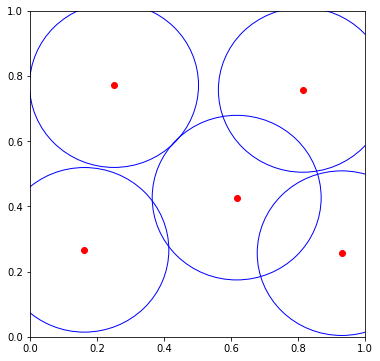

In [59]:
plot_lamps(final_pop[0].candidate, problem_size)